<a href="https://colab.research.google.com/github/FranciscoMendizabal/TP2_Redes/blob/main/TP_Segmentaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!unzip PhC-C2DH-U373.zip

Archive:  PhC-C2DH-U373.zip
replace PhC-C2DH-U373/01/t000.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [3]:
from PIL import Image

# Cargo Train y Validacion

Train será aumentado

In [4]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [5]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [6]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

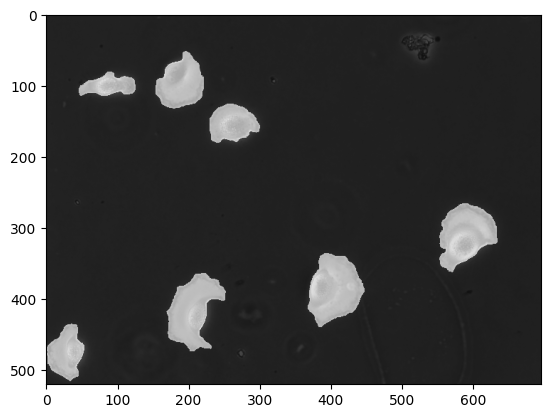

In [7]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [8]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [9]:
x_train[0,:,:,0].max()

0.7254901960784313

In [10]:
len(x_train)

115

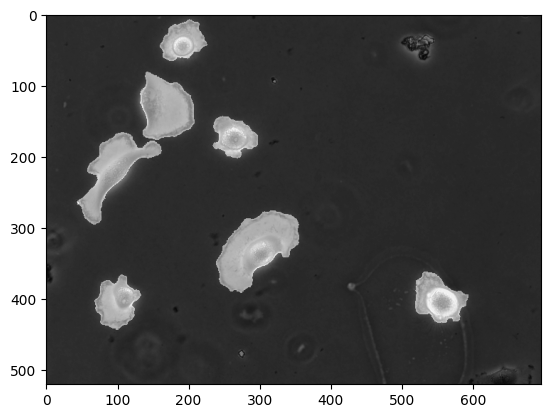

In [11]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [12]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions

In [32]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Armo la red de preprocesamiento para hacer aumentación en la GPU

In [13]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

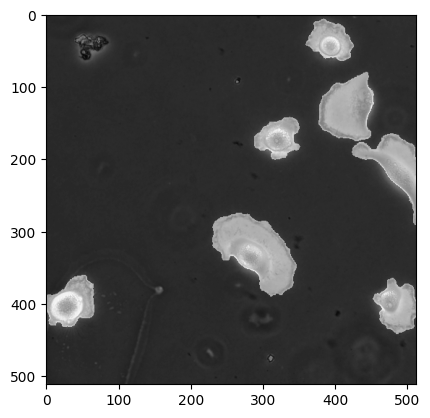

In [14]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [15]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [56]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [100]:
red_falopa = get_red_seg()

In [101]:
red_falopa.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, None, None, 16)    1616      
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 16)    25616     
                                                                 
 conv2d_20 (Conv2D)          (None, None, None, 16)    25616     
                                                                 
 conv2d_21 (Conv2D)          (None, None, None, 16)    25616     
                                                                 
 conv2d_22 (Conv2D)          (None, None, None, 16)    25616     
                                                                 
 conv2d_23 (Conv2D)          (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [102]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa, preproc_val)

In [103]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [41]:
len(x_val)

115

In [ ]:
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

In [105]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [106]:
pred.numpy().max()

1.0

In [107]:
pred.numpy().min()

3.6205098e-20

In [108]:
dice_coef(x_val[0:1,:,:,1:2], pred.numpy().astype(np.float64))

<tf.Tensor: shape=(), dtype=float64, numpy=0.8674389591755641>

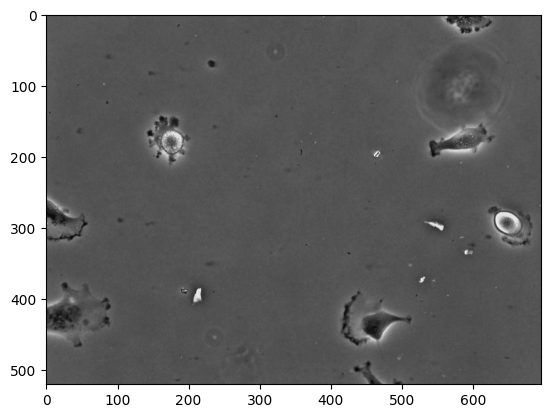

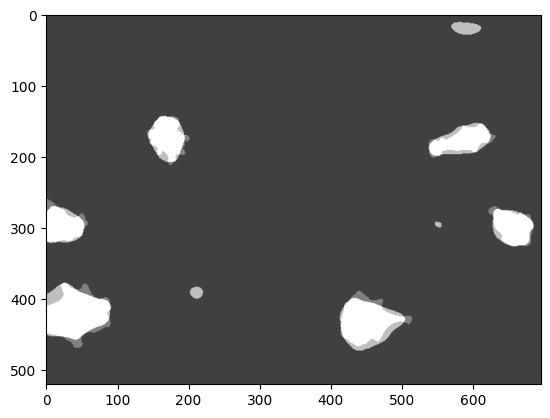

In [ ]:
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

In [17]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

In [18]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [65]:
K.clear_session()

In [66]:
preproc_unet = get_preproc()
preproc_unet_val = get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = False
)
model_unet = SegmentationModel(preproc_unet, red_unet, preproc_unet_val)

In [67]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [68]:
model_unet.fit(np.vstack([x_train, x_val]), batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 16s 991ms/step - loss: 0.6401 - val_loss: 0.6130
Epoch 2/100
8/8 [==============================] - 6s 753ms/step - loss: 0.6102 - val_loss: 0.5664
Epoch 3/100
8/8 [==============================] - 7s 912ms/step - loss: 0.5253 - val_loss: 0.2451
Epoch 4/100
8/8 [==============================] - 7s 928ms/step - loss: 0.3637 - val_loss: 0.2577
Epoch 5/100
8/8 [==============================] - 6s 727ms/step - loss: 0.3623 - val_loss: 0.1916
Epoch 6/100
8/8 [==============================] - 7s 933ms/step - loss: 0.3482 - val_loss: 0.2369
Epoch 7/100
8/8 [==============================] - 6s 736ms/step - loss: 0.3368 - val_loss: 0.1867
Epoch 8/100
8/8 [==============================] - 6s 732ms/step - loss: 0.3332 - val_loss: 0.2022
Epoch 9/100
8/8 [==============================] - 6s 731ms/step - loss: 0.3311 - val_loss: 0.2056
Epoch 10/100
8/8 [==============================] - 6s 749ms/step - loss: 0.3116 - val_loss: 0.1988
Epoch 11

In [69]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [62]:
pred.numpy().max()

0.9977835

In [63]:
pred.numpy().min()

1.7923979e-13

In [64]:
dice_coef(aux[0:1,:,:,1], pred.numpy())

<tf.Tensor: shape=(), dtype=float32, numpy=0.84205866>

In [45]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

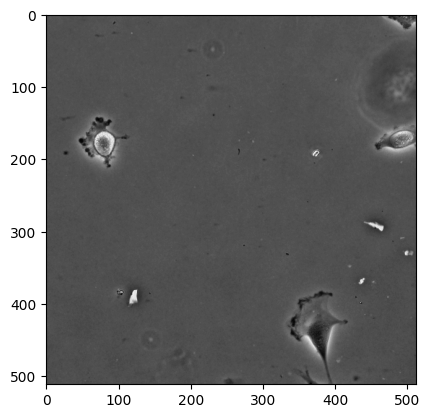

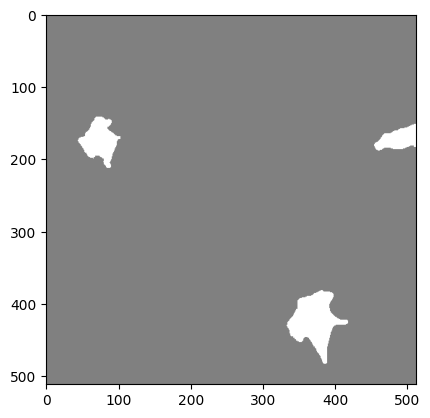

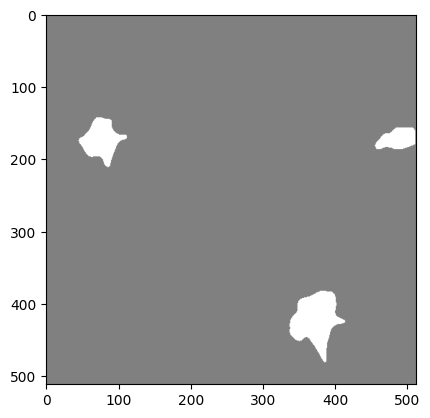

In [70]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

# Explicacion de las redes

La Atrous Convolutional es una CNN que utiliza un factor de dilatación, el cual le permite expandir el campo perceptual de una capa convolucional sin aumentar la cantidad de parámetros. Esto posibilita que la red capture características de "alta frecuencia" en las capas donde el factor es pequeño, y las de "baja frecuencia" cuando este toma un valor más alto. Una gran ventaja de este tipo de red, es que puede obtener una buena performance con un costo computacional menor al de muchos otros tipos de redes convolucionales.


La U-Net es un autoencoder, es decir, consiste de dos partes principales. El "encoder" es donde se capturan las características de alto nivel de la imagen, mientras que gradualmente se reduce la dimensionalidad de las capas. El "decoder" aumenta nuevamente la dimensionalidad, permitiendo reconstruir la imagen original con ayuda de las conexiones residuales. Debido a estas conexiones, se pueden preservar ciertos detalles en las imágenes, lo cual resulta beneficioso en aplicaciones como segmentación.



Se hicieron las siguientes pruebas:
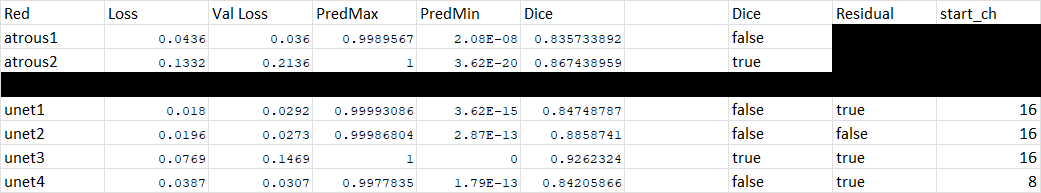

En primer lugar se prueba la red Atrous, con binary cross entropy y el coeficiente de dice como función de costo. Vemos que trabajar sobre el dice produce mejores resultados (lo cual tiene sentido dado que es una de las métricas que utilizamos para medir la performance, mientras que la loss no lo es).

Por otro lado, la U-Net resultó de mayor interés dado que tenía más parámetros modificables, y a su vez produjo resultados ligeramente superiores a la Atrous. Se observa que al quitar las conexiones residuales, aumentó el coeficiente de dice, pero también empeoraron los valores de las predicciones máxima y mínima. Este resultado es notable, dado que no se esperaban buenos resultados en esta prueba. Al igual que antes, también se probó utilizar el coeficiente de dice como función de costo, mejorando el rendimiento de la red. Finalmente, se evaluó si podía lograrse un resultado similar utilizando menos capas, pero se observa que esto no es así.

Cabe destacar que la U-Net utiliza el orden de 10 veces la cantidad de parámetros requeridos por la Atrous, logrando un rendimiento similar, lo cual demuestra la diferencia en complejidad computacional explicada en la teoría.